In [1]:
import numpy as np
from scipy import signal as sgl
from matplotlib import pyplot as plt
import numba
import matplotlib as mpl
from parameters_info import sample_uniform_within_range
mpl.rcParams['font.size'] = 20

Simulator functions that implement the Euler and Heun method with and without noise (additive white noise)

In [2]:
####################### No noise #######################

@numba.njit 
def simulate_euler(parameters,length: int = 302, dt: int = 1, num_sim: int = 2000, initial_conditions = np.array([0.25,0.25])):
    # Input parameters are of shape (num_nodes, num_parameters) to match parameter estimation output, but we need (num_parameters,num_nodes) to simulate
    params = parameters.T 
    # Equivalent to allocating memory
    time_series_E = np.empty((int(1000/dt*length),int(num_sim)))
    time_series_I = np.empty((int(1000/dt*length),int(num_sim)))
    # Set initial conditions
    time_series_E[0] = initial_conditions[0]
    time_series_I[0] = initial_conditions[1]
    # Forward euler performed in-place within the time_series_X arrays to maximize speed
    for i in range(int(1000/dt*length)-1):
        time_series_E[i+1] = params[0] * time_series_E[i] - params[2] * time_series_I[i] + params[18] - params[9]
        time_series_I[i+1] = params[1] * time_series_E[i] - params[3] * time_series_I[i] + params[19] - params[13]
        time_series_E[i+1] = params[8] / (1 + np.exp(-params[6]* (params[20] * time_series_E[i+1] - params[7])))
        time_series_I[i+1] = params[12] / (1 + np.exp(-params[10]* (params[21] * time_series_I[i+1] - params[11])))
        time_series_E[i+1] = dt * (((params[16] - params[14] * time_series_E[i]) * time_series_E[i+1]) - time_series_E[i]) / params[4] 
        time_series_I[i+1] = dt * (((params[17] - params[15] * time_series_I[i]) * time_series_I[i+1]) - time_series_I[i]) / params[5] 
        time_series_E[i+1] += time_series_E[i] 
        time_series_I[i+1] += time_series_I[i] 
    return time_series_E, time_series_I

@numba.njit
def simulate_heun(parameters, length: int = 302, dt: int = 1, num_sim: int = 2000, initial_conditions = np.array([0.25,0.25])):
    # Input parameters are of shape (num_nodes, num_parameters) to match parameter estimation output, but we need (num_parameters,num_nodes) to simulate
    params = parameters.T 
    # Equivalent to allocating memory
    time_series_E = np.empty((int(1000/dt*length),int(num_sim)))
    time_series_I = np.empty((int(1000/dt*length),int(num_sim)))
    time_series_E_temp = np.empty((1,int(num_sim)))
    time_series_I_temp = np.empty((1,int(num_sim)))
    time_series_E_corr = np.empty((1,int(num_sim)))
    time_series_I_corr = np.empty((1,int(num_sim)))
    # Set initial conditions
    time_series_E[0] = initial_conditions[0]
    time_series_I[0] = initial_conditions[1]
    # Forward heun performed in-place within the time_series_X arrays to maximize speed
    for i in range(int(1000/dt*length)-1):
        # Forward euler
        time_series_E[i+1] = params[0] * time_series_E[i] - params[2] * time_series_I[i] + params[18] - params[9]
        time_series_I[i+1] = params[1] * time_series_E[i] - params[3] * time_series_I[i] + params[19] - params[13]
        time_series_E[i+1] = params[8] / (1 + np.exp(-params[6]* (params[20] * time_series_E[i+1] - params[7])))
        time_series_I[i+1] = params[12] / (1 + np.exp(-params[10]* (params[21] * time_series_I[i+1] - params[11])))
        time_series_E[i+1] = dt*(((params[16] - params[14] * time_series_E[i]) * time_series_E[i+1]) - time_series_E[i]) / params[4] 
        time_series_I[i+1] = dt*(((params[17] - params[15] * time_series_I[i]) * time_series_I[i+1]) - time_series_I[i]) / params[5] 
        time_series_E_temp = time_series_E[i] + time_series_E[i+1] 
        time_series_I_temp = time_series_I[i] + time_series_I[i+1]
        # Corrector point
        time_series_E_corr = params[0] * time_series_E_temp - params[2] * time_series_I_temp + params[18] - params[9]
        time_series_I_corr = params[1] * time_series_E_temp - params[3] * time_series_I_temp + params[19] - params[13]
        time_series_E_corr = params[8] / (1 + np.exp(-params[6]* (params[20] * time_series_E_corr - params[7])))
        time_series_I_corr = params[12] / (1 + np.exp(-params[10]* (params[21] * time_series_I_corr - params[11])))
        time_series_E_corr = dt*(((params[16] - params[14] * time_series_E_temp) * time_series_E_corr) - time_series_E_temp) / params[4] 
        time_series_I_corr = dt*(((params[17] - params[15] * time_series_I_temp) * time_series_I_corr) - time_series_I_temp) / params[5]
        # Heun point
        time_series_E[i+1] = time_series_E[i] + (time_series_E[i+1]+time_series_E_corr)/2 
        time_series_I[i+1] = time_series_I[i] + (time_series_I[i+1]+time_series_I_corr)/2         
    return time_series_E, time_series_I


####################### With noise #######################

@numba.njit 
def simulate_euler_noise(parameters, length: int = 302, dt: int = 1, num_sim: int = 2000, initial_conditions = np.array([0.25,0.25]), noise_seed: int = 42):
    # Input parameters are of shape (num_nodes, num_parameters) to match parameter estimation output, but we need (num_parameters,num_nodes) to simulate
    params = parameters.T 
    # Set seed
    np.random.seed(noise_seed)
    # White noise
    DE, DI = np.sqrt(2*params[-1]), np.sqrt(2*params[-2])
    # Equivalent to allocating memory
    time_series_E = np.empty((int(1000/dt*length),int(num_sim)))
    time_series_I = np.empty((int(1000/dt*length),int(num_sim)))
    # Set initial conditions
    time_series_E[0] = initial_conditions[0]
    time_series_I[0] = initial_conditions[1]
    # Forward euler performed in-place within the time_series_X arrays to maximize speed
    for i in range(int(1000/dt*length)-1):
        time_series_E[i+1] = params[0] * time_series_E[i] - params[2] * time_series_I[i] + params[18] - params[9]
        time_series_I[i+1] = params[1] * time_series_E[i] - params[3] * time_series_I[i] + params[19] - params[13]
        time_series_E[i+1] = params[8] / (1 + np.exp(-params[6]* (params[20] * time_series_E[i+1] - params[7])))
        time_series_I[i+1] = params[12] / (1 + np.exp(-params[10]* (params[21] * time_series_I[i+1] - params[11])))
        time_series_E[i+1] = dt * (((params[16] - params[14] * time_series_E[i]) * time_series_E[i+1]) - time_series_E[i]) / params[4] 
        time_series_I[i+1] = dt * (((params[17] - params[15] * time_series_I[i]) * time_series_I[i+1]) - time_series_I[i]) / params[5] 
        time_series_E[i+1] += time_series_E[i] + np.random.normal(0,1,size=num_sim) *  DE
        time_series_I[i+1] += time_series_I[i] + np.random.normal(0,1,size=num_sim) *  DI 
    return time_series_E, time_series_I

@numba.njit
def simulate_heun_noise(parameters, length: int = 302, dt: int = 1, num_sim: int = 2000, initial_conditions = np.array([0.25,0.25]), noise_seed: int = 42):
    # Input parameters are of shape (num_nodes, num_parameters) to match parameter estimation output, but we need (num_parameters,num_nodes) to simulate
    params = parameters.T 
    # Set seet
    np.random.seed(noise_seed)
    # White noise
    DE, DI = np.sqrt(2*params[-1]), np.sqrt(2*params[-2])
    # Equivalent to allocating memory
    time_series_E = np.empty((int(1000/dt*length),int(num_sim)))
    time_series_I = np.empty((int(1000/dt*length),int(num_sim)))
    time_series_E_temp = np.empty((1,int(num_sim)))
    time_series_I_temp = np.empty((1,int(num_sim)))
    time_series_E_corr = np.empty((1,int(num_sim)))
    time_series_I_corr = np.empty((1,int(num_sim)))
    time_series_E_noise = np.empty((1,int(num_sim)))
    time_series_I_noise = np.empty((1,int(num_sim)))
    # Set initial conditions
    time_series_E[0] = initial_conditions[0]
    time_series_I[0] = initial_conditions[1]
    # Heun performed in-place within the time_series_X arrays to maximize speed
    for i in range(int(1000/dt*length)-1):
        # Forward Euler
        time_series_E[i+1] = params[0] * time_series_E[i] - params[2] * time_series_I[i] + params[18] - params[9]
        time_series_I[i+1] = params[1] * time_series_E[i] - params[3] * time_series_I[i] + params[19] - params[13]
        time_series_E[i+1] = params[8] / (1 + np.exp(-params[6]* (params[20] * time_series_E[i+1] - params[7])))
        time_series_I[i+1] = params[12] / (1 + np.exp(-params[10]* (params[21] * time_series_I[i+1] - params[11])))
        time_series_E[i+1] = dt*(((params[16] - params[14] * time_series_E[i]) * time_series_E[i+1]) - time_series_E[i]) / params[4] 
        time_series_I[i+1] = dt*(((params[17] - params[15] * time_series_I[i]) * time_series_I[i+1]) - time_series_I[i]) / params[5] 
        time_series_E_noise = np.random.normal(0,1,size=num_sim) *  DE
        time_series_I_noise = np.random.normal(0,1,size=num_sim) *  DI
        time_series_E_temp = time_series_E[i] + time_series_E[i+1] + time_series_E_noise
        time_series_I_temp = time_series_I[i] + time_series_I[i+1] + time_series_I_noise
        # Corrector point
        time_series_E_corr = params[0] * time_series_E_temp - params[2] * time_series_I_temp + params[18] - params[9]
        time_series_I_corr = params[1] * time_series_E_temp - params[3] * time_series_I_temp + params[19] - params[13]
        time_series_E_corr = params[8] / (1 + np.exp(-params[6]* (params[20] * time_series_E_corr - params[7])))
        time_series_I_corr = params[12] / (1 + np.exp(-params[10]* (params[21] * time_series_I_corr - params[11])))
        time_series_E_corr = dt*(((params[16] - params[14] * time_series_E_temp) * time_series_E_corr) - time_series_E_temp) / params[4] 
        time_series_I_corr = dt*(((params[17] - params[15] * time_series_I_temp) * time_series_I_corr) - time_series_I_temp) / params[5]
        # Heun point
        time_series_E[i+1] = time_series_E[i] + (time_series_E[i+1]+time_series_E_corr)/2 + time_series_E_noise
        time_series_I[i+1] = time_series_I[i] + (time_series_I[i+1]+time_series_I_corr)/2 + time_series_I_noise  
    return time_series_E, time_series_I


Known parameter points 

In [3]:
parameters_original = np.array([1.6000e+01, 1.2000e+01, 1.5000e+01, 3.0000e+00, 8.0000e+00, 8.0000e+00,
        1.3000e+00, 4.0000e+00, 1.0000e+00, 0.0000e+00, 2.0000e+00, 3.7000e+00,
        1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.500e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,5.0000e-07,5.0000e-07])

parameters_alpha_peak = np.array([1.6000e+01, 1.2000e+01, 1.5000e+01, 3.0000e+00, 28.0000e+00, 28.0000e+00,
        1.3000e+00, 4.0000e+00, 1.0000e+00, 0.0000e+00, 2.0000e+00, 3.7000e+00,
        1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.500e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,5.0000e-07,5.0000e-07])
parameter_samples = sample_uniform_within_range(1500)

Testing and visualizing both integration schemes without noise. Also looking at the power spectrum.

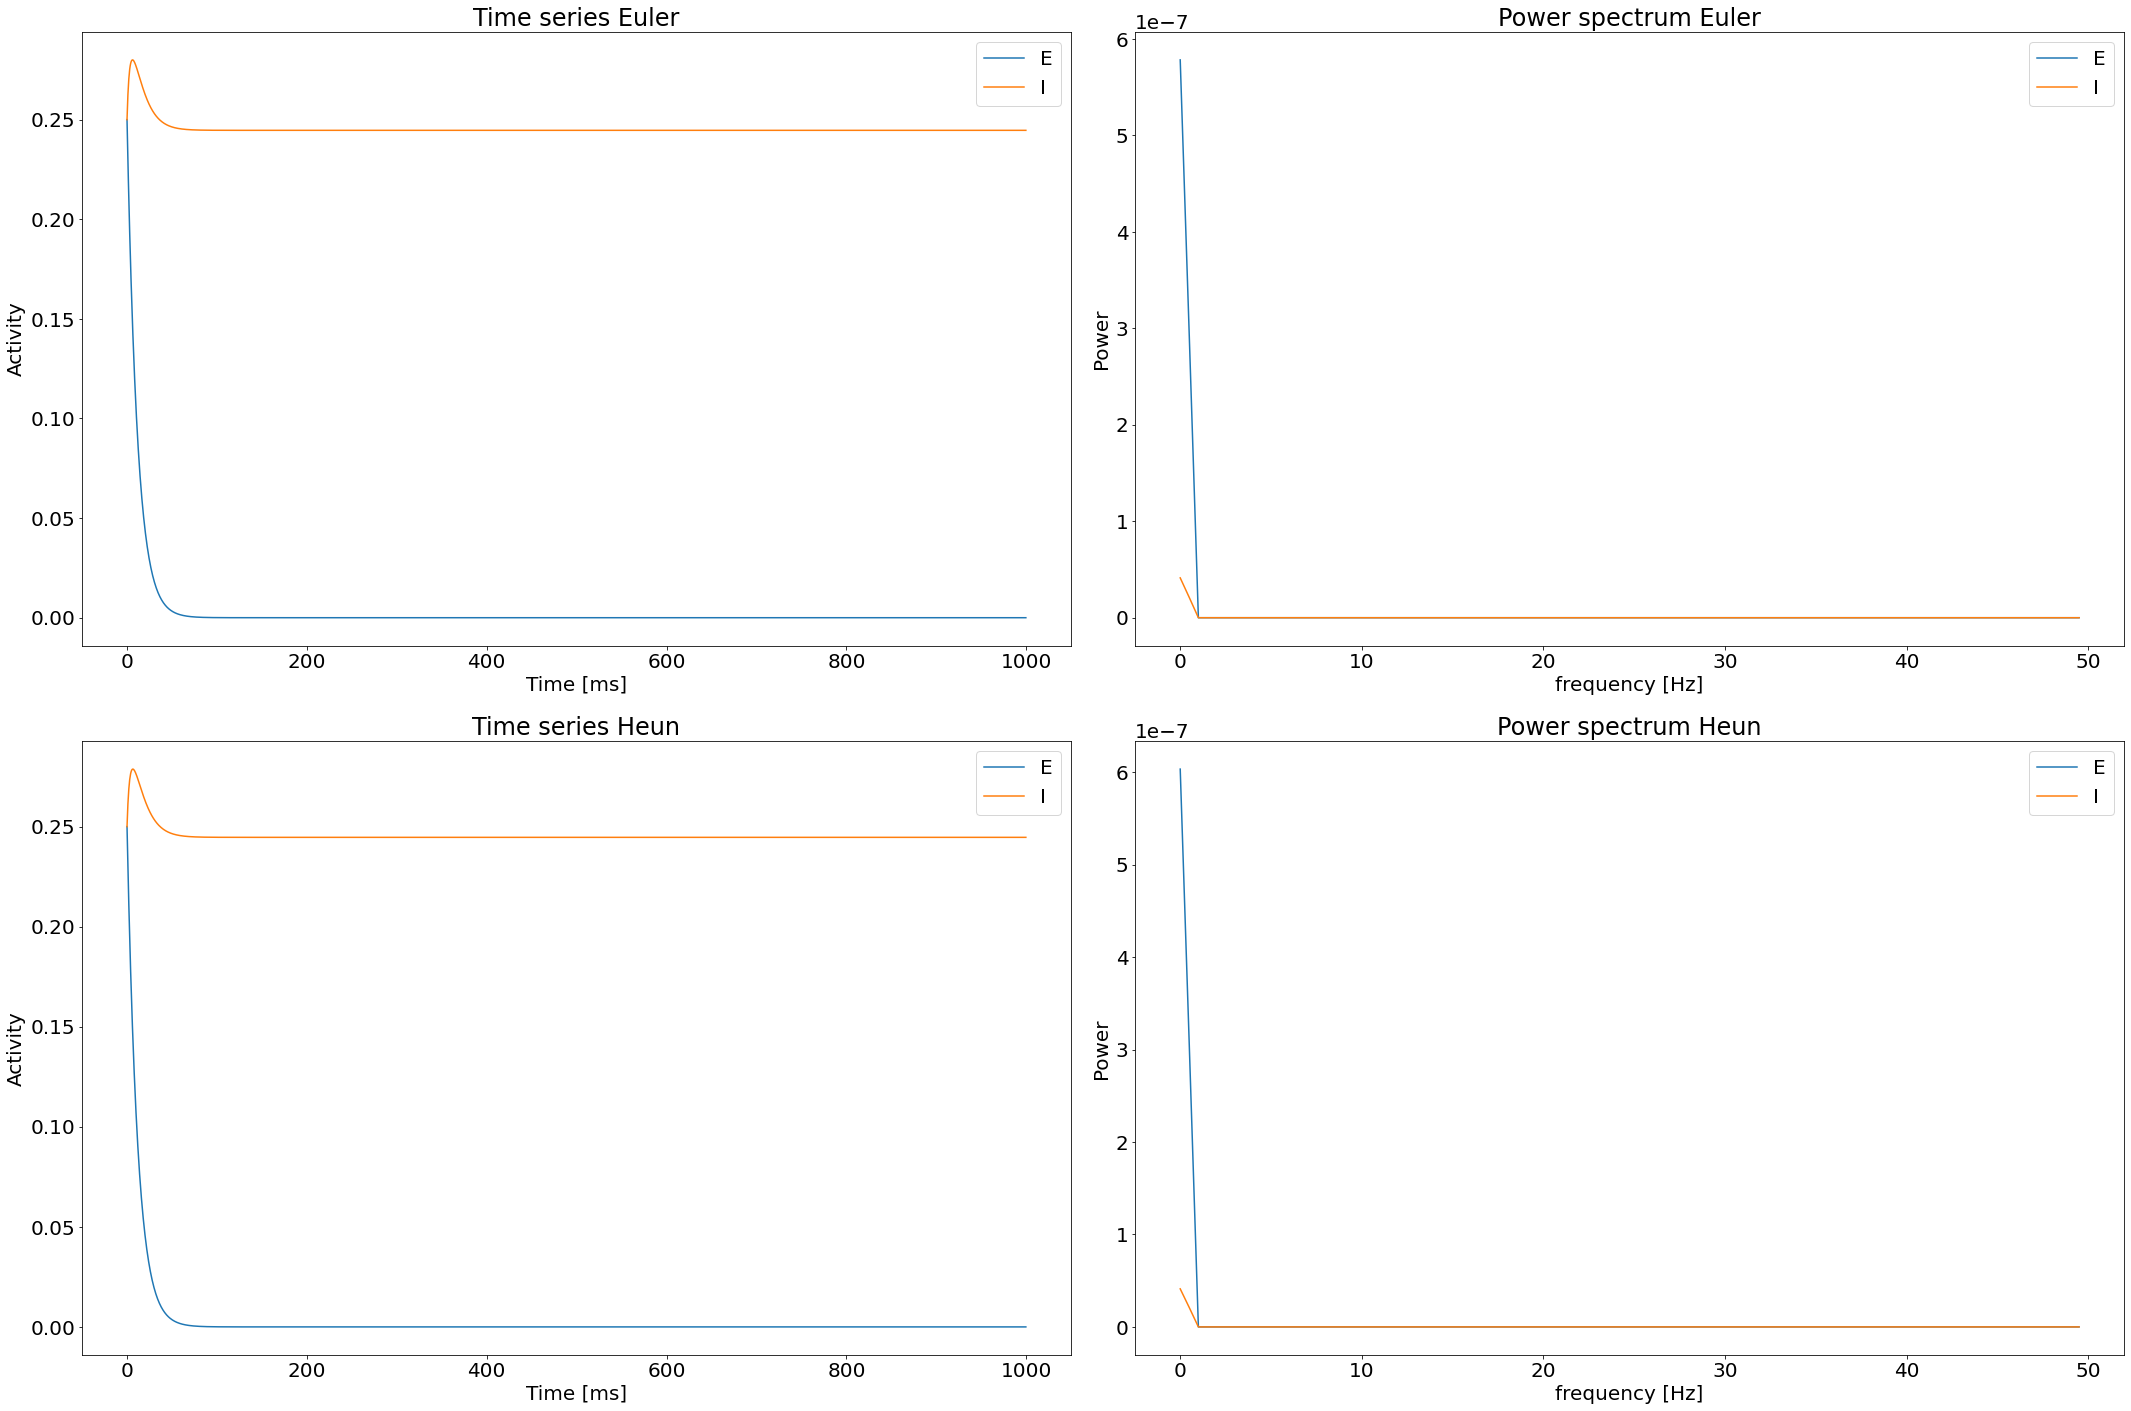

In [18]:
parameters = parameter_samples[:2]#np.array([parameters_alpha_peak,parameters_original])
dt = 0.5

# Simulate
time_series_E, time_series_I = simulate_euler(parameters,length = 6.0, dt=dt, num_sim = parameters.shape[0])
t = np.arange(int(1000/dt))*dt

# PLot
f = plt.figure(figsize=(30,20))
# Timeseries
ax = plt.subplot(2,2,1)
ax.plot(t,time_series_E[:int(1000/dt),0], label = "E")
ax.plot(t,time_series_I[:int(1000/dt),0], label = "I")
plt.xlabel('Time [ms]')
plt.ylabel('Activity')
plt.title('Time series Euler')
plt.legend()
# PSD
ax = plt.subplot(2,2,2)
f , psd = sgl.welch(time_series_E[:,0],fs=(1000/dt), nperseg=2000/dt)
plt.plot(f[:100],psd[:100], label = "E")
f , psd = sgl.welch(time_series_I[:,0],fs=(1000/dt), nperseg=2000/dt)
plt.plot(f[:100],psd[:100], label = "I")
plt.xlabel('frequency [Hz]')
plt.ylabel('Power')
plt.title('Power spectrum Euler')
plt.legend()

time_series_E, time_series_I = simulate_heun(parameters,length = 6.0, dt=dt, num_sim = parameters.shape[0])

# Timeseries
ax = plt.subplot(2,2,3)
ax.plot(t,time_series_E[:int(1000/dt),0], label = "E")
ax.plot(t,time_series_I[:int(1000/dt),0], label = "I")
plt.xlabel('Time [ms]')
plt.ylabel('Activity')
plt.title('Time series Heun')
plt.legend()
# PSD
ax = plt.subplot(2,2,4)
f , psd = sgl.welch(time_series_E[:,0],fs=(1000/dt), nperseg=2000/dt)
plt.plot(f[:100],psd[:100], label = "E")
f , psd = sgl.welch(time_series_I[:,0],fs=(1000/dt), nperseg=2000/dt)
plt.plot(f[:100],psd[:100], label = "I")
plt.xlabel('frequency [Hz]')
plt.ylabel('Power')
plt.title('Power spectrum Heun')
plt.legend()
plt.tight_layout()
plt.show()

Looking at the difference between the integration schemes without noise.

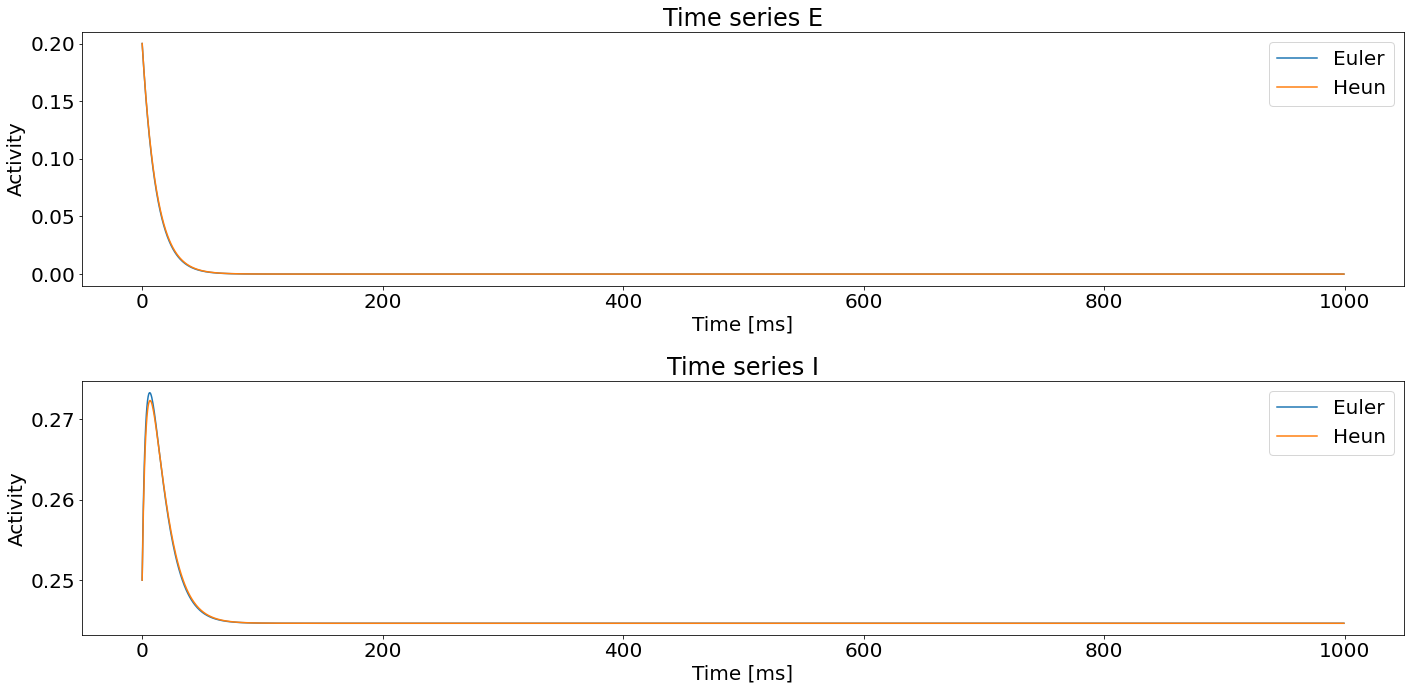

In [19]:
dt = 0.5
# Simulate
euler_time_series_E, euler_time_series_I = simulate_euler(parameters,length = 1.0, dt=dt, num_sim = parameters.shape[0], initial_conditions=np.array([0.2,0.25]))
heun_time_series_E, heun_time_series_I = simulate_heun(parameters,length = 1.0, dt=dt, num_sim = parameters.shape[0], initial_conditions=np.array([0.2,0.25]))
t = np.arange(int(1000/dt))*dt
# Plot
f = plt.figure(figsize=(20,10))
# Timeseries E
ax = plt.subplot(2,1,1)
ax.plot(t,euler_time_series_E[:int(1000/dt),0], label = "Euler")
ax.plot(t,heun_time_series_E[:int(1000/dt),0], label = "Heun")
plt.xlabel('Time [ms]')
plt.ylabel('Activity')
plt.title('Time series E')
plt.legend()
# Timeseries I
ax = plt.subplot(2,1,2)
ax.plot(t,euler_time_series_I[:int(1000/dt),0], label = "Euler")
ax.plot(t,heun_time_series_I[:int(1000/dt),0], label = "Heun")
plt.xlabel('Time [ms]')
plt.ylabel('Activity')
plt.title('Time series I')
plt.legend()
plt.tight_layout()
plt.show()

Testing and visualizing both integration schemes with noise. Also looking at the power spectrum.

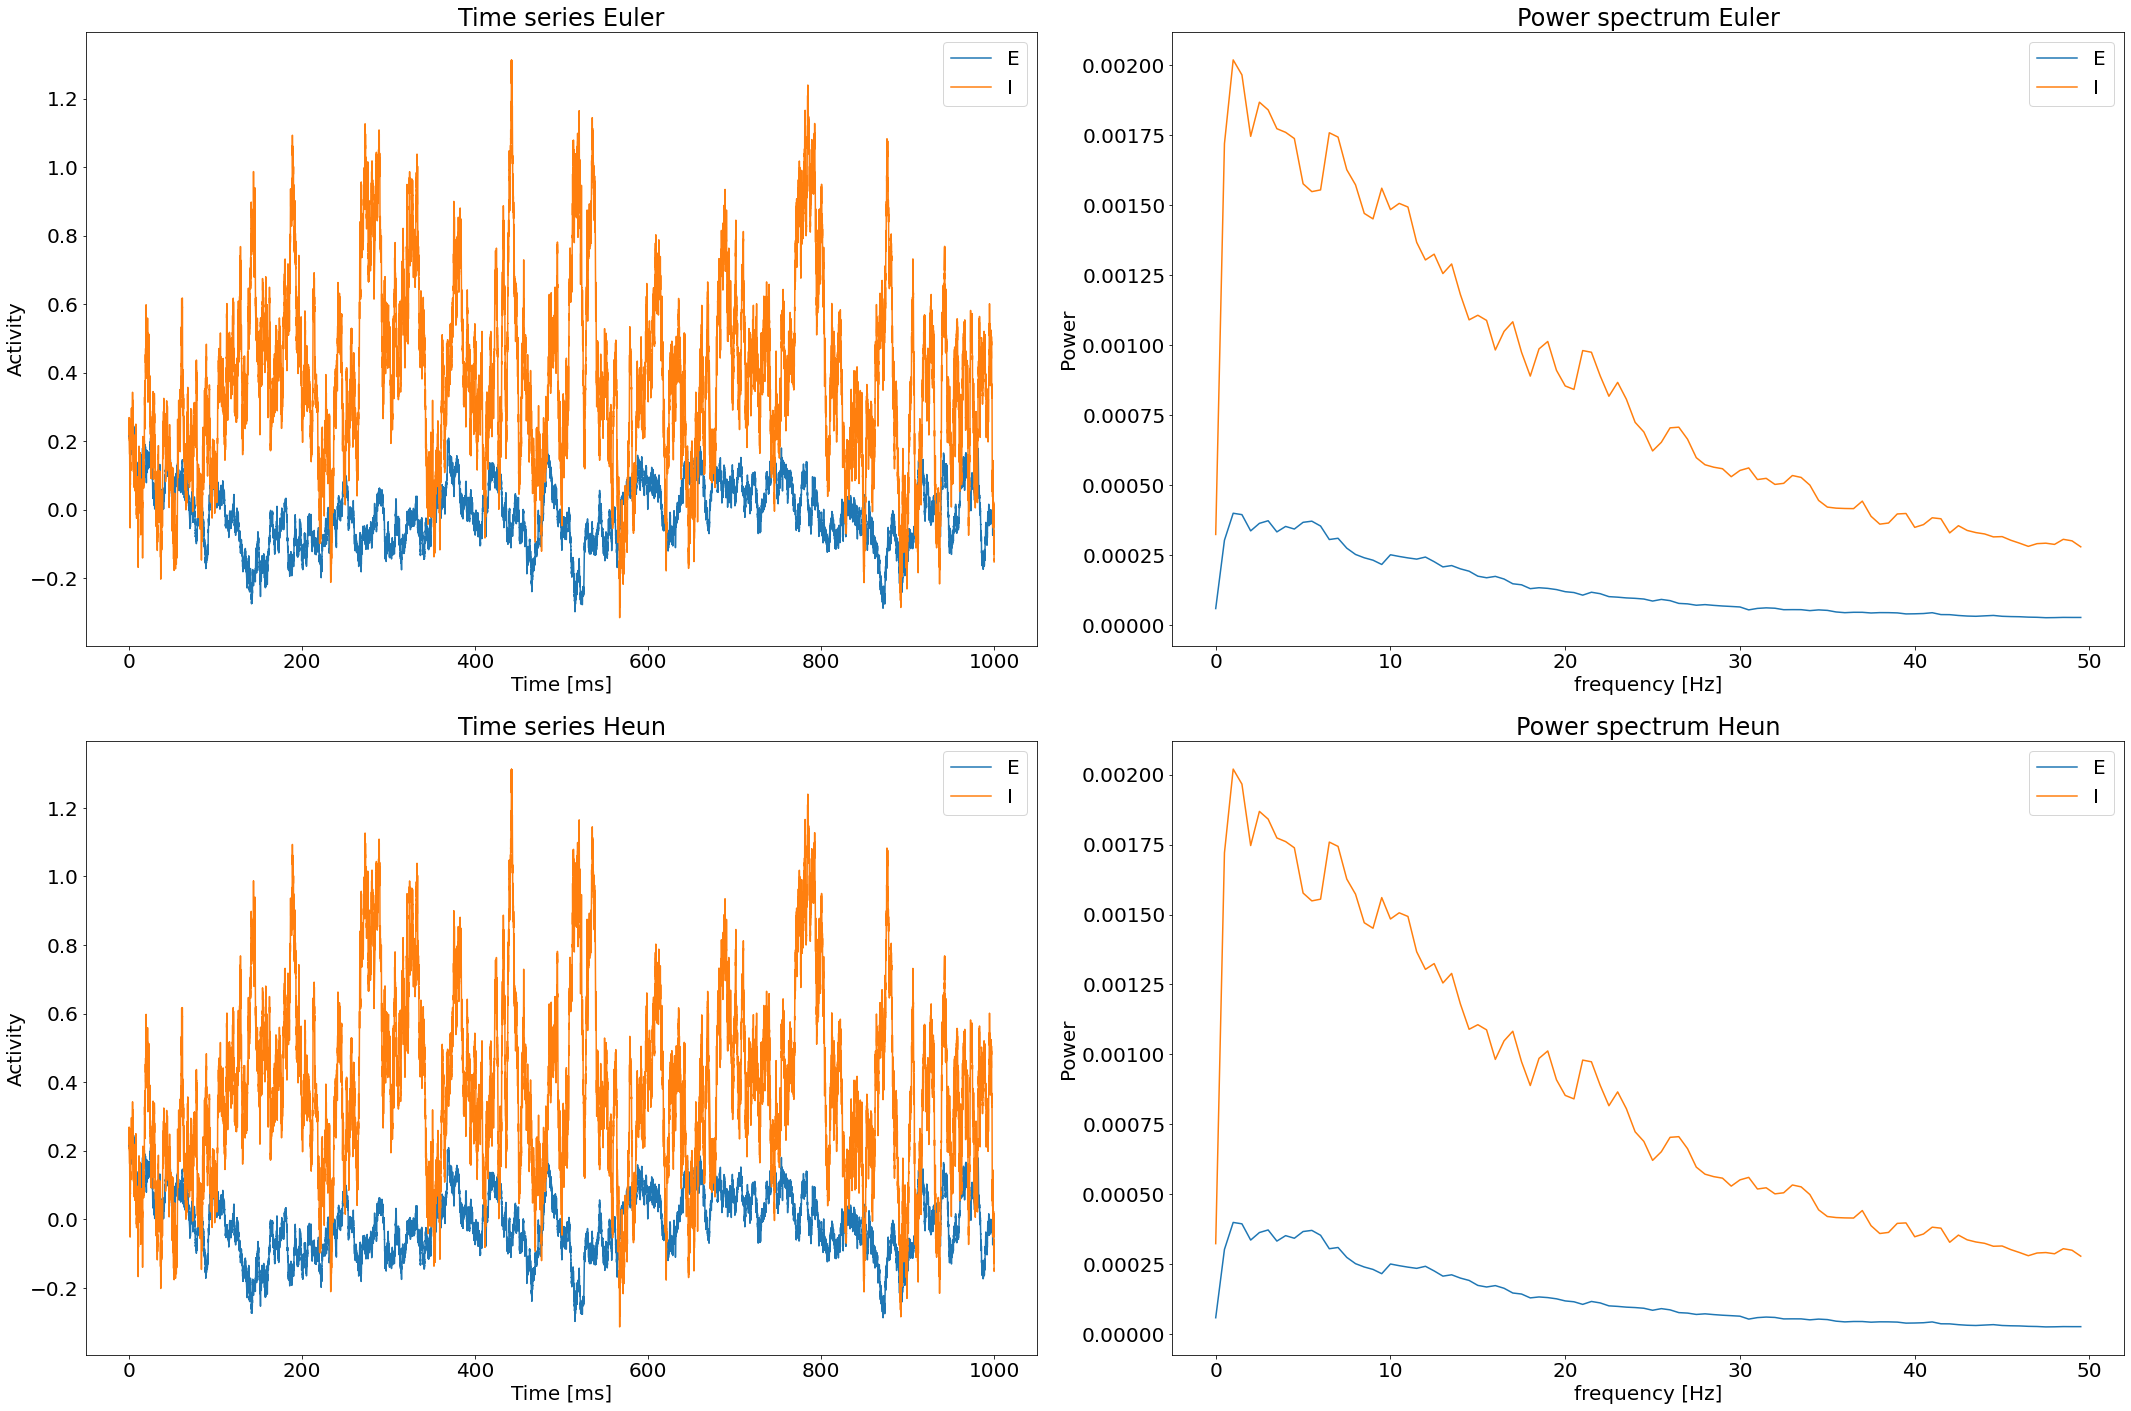

In [20]:
parameters = parameter_samples[:2]#np.array([parameters_alpha_peak])
dt = 0.02
length = 302

# Simulate euler
time_series_E, time_series_I = simulate_euler_noise(parameters,length = length, dt=dt, num_sim = parameters.shape[0], noise_seed=12)
t = np.arange(int(1000/dt))*dt

# PLot
f = plt.figure(figsize=(30,20))
# Timeseries
ax = plt.subplot(2,2,1)
ax.plot(t,time_series_E[:int(1000/dt),0], label = "E")
ax.plot(t,time_series_I[:int(1000/dt),0], label = "I")
plt.xlabel('Time [ms]')
plt.ylabel('Activity')
plt.title('Time series Euler')
plt.legend()
# PSD
ax = plt.subplot(2,2,2)
f , psd = sgl.welch(time_series_E[:,0],fs=(1000/dt), nperseg=2000/dt)
plt.plot(f[:100],psd[:100], label = "E")
f , psd = sgl.welch(time_series_I[:,0],fs=(1000/dt), nperseg=2000/dt)
plt.plot(f[:100],psd[:100], label = "I")
plt.xlabel('frequency [Hz]')
plt.ylabel('Power')
plt.title('Power spectrum Euler')
plt.legend()

# Simulate heun
time_series_E, time_series_I = simulate_heun_noise(parameters,length = length, dt=dt, num_sim = parameters.shape[0],noise_seed=12)

# Timeseries
ax = plt.subplot(2,2,3)
ax.plot(t,time_series_E[:int(1000/dt),0], label = "E")
ax.plot(t,time_series_I[:int(1000/dt),0], label = "I")
plt.xlabel('Time [ms]')
plt.ylabel('Activity')
plt.title('Time series Heun')
plt.legend()
# PSD
ax = plt.subplot(2,2,4)
f , psd = sgl.welch(time_series_E[:,0],fs=(1000/dt), nperseg=2000/dt)
plt.plot(f[:100],psd[:100], label = "E")
f , psd = sgl.welch(time_series_I[:,0],fs=(1000/dt), nperseg=2000/dt)
plt.plot(f[:100],psd[:100], label = "I")
plt.xlabel('frequency [Hz]')
plt.ylabel('Power')
plt.title('Power spectrum Heun')
plt.legend()
plt.tight_layout()
plt.show()

Looking at the difference between the integration schemes with noise

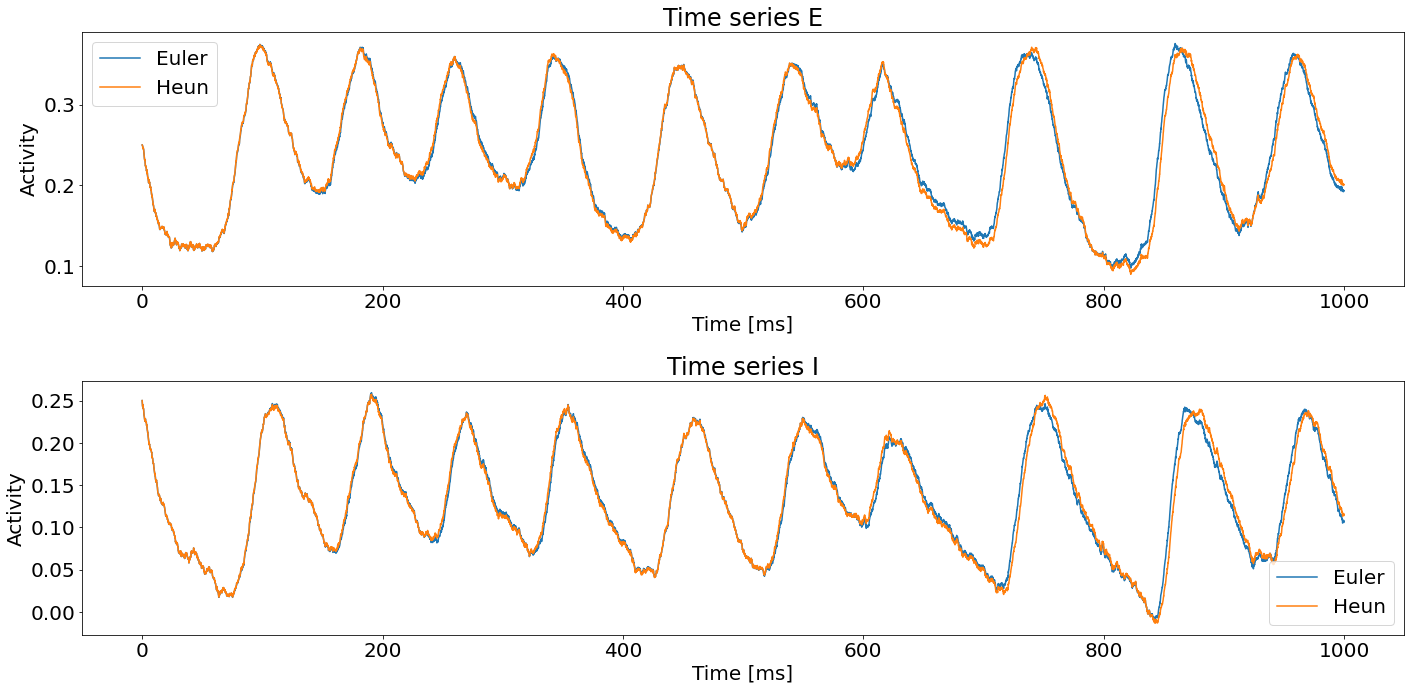

In [5]:
dt = 0.1
length = 6.0

# Simulate
noisy_euler_time_series_E, noisy_euler_time_series_I = simulate_euler_noise(parameters,length = length, dt=dt, num_sim = parameters.shape[0], noise_seed=12)
noisy_heun_time_series_E, noisy_heun_time_series_I = simulate_heun_noise(parameters,length = length, dt=dt, num_sim = parameters.shape[0], noise_seed=12)
t = np.arange(int(1000/dt))*dt
# Plot
f = plt.figure(figsize=(20,10))
# Timeseries E
ax = plt.subplot(2,1,1)
ax.plot(t,noisy_euler_time_series_E[:int(1000/dt),0], label = "Euler")
ax.plot(t,noisy_heun_time_series_E[:int(1000/dt),0], label = "Heun")
plt.xlabel('Time [ms]')
plt.ylabel('Activity')
plt.title('Time series E')
plt.legend()
# Timeseries I
ax = plt.subplot(2,1,2)
ax.plot(t,noisy_euler_time_series_I[:int(1000/dt),0], label = "Euler")
ax.plot(t,noisy_heun_time_series_I[:int(1000/dt),0], label = "Heun")
plt.xlabel('Time [ms]')
plt.ylabel('Activity')
plt.title('Time series I')
plt.legend()
plt.tight_layout()
plt.show()

Testing the runtime of the simulators with a large number of parallel simulations (single core)

In [150]:
# The parameter input from the parameter estimation algorithms will be an array of single node parameter points. Shape: (Num_nodes, Num_params)
batch_parameters = np.array([parameters_alpha_peak for i in range(1500)])
print(batch_parameters.shape)

(1500, 24)


In [153]:
# Simulate 36.8s runtime
euler_time_series_E, euler_time_series_I = simulate_euler(batch_parameters,length=302,dt=1, num_sim = 1500)

In [154]:
# To free memory, since it takes at least 5 to 10GB of RAM to contain the results
euler_time_series_E, euler_time_series_I = None, None

In [155]:
# Simulate 1min 1.3s runtime
euler_time_series_E, euler_time_series_I = simulate_euler_noise(batch_parameters,length=302,dt=1, num_sim = 1500)

In [156]:
# To free memory, since it takes at least 5 to 10GB of RAM to contain the results
euler_time_series_E, euler_time_series_I = None, None

In [159]:
# Simulate 60.4s runtime
heun_time_series_E, heun_time_series_I = simulate_heun(batch_parameters,length=302,dt=1, num_sim = 1500)

In [160]:
# To free memory, since it takes at least 5 to 10GB of RAM to contain the results
heun_time_series_E, heun_time_series_I = None, None

In [161]:
# Simulate 1min 34.5s runtime
heun_time_series_E, heun_time_series_I = simulate_heun_noise(batch_parameters,length=302,dt=1, num_sim = 1500)

In [163]:
# To free memory, since it takes at least 5 to 10GB of RAM to contain the results
heun_time_series_E, heun_time_series_I = None, None